## Training a GAN on Fashion MNIST

#### Setting for hot reloading of modules

In [1]:
%load_ext autoreload
%autoreload 2

#### Importing modules

In [2]:
import lightning as L
import torchvision
import torchvision.transforms as transforms
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from torch.utils.data import DataLoader

from src.models.discriminator import Discriminator
from src.models.generator import Generator
from src.train.wrapper.gan_wrapper import GANWrapper
from src.utils.constants import Paths
from src.utils.helpers import detect_device, matplotlib_imshow

#### Setting up the data

In [3]:
BATCH_SIZE = 512

#### Downloading and preparing the data

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST(Paths.DATA_DIR, train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST(Paths.DATA_DIR, train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


#### Defining the model hyperparameters

In [5]:
input_dim = 28 * 28
hidden_dim = 400
latent_dim = 200

#### Visualizing the data

torch.Size([3, 1922, 242])
Bag  Bag  Coat  Sandal


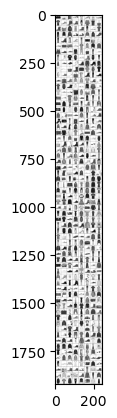

In [6]:
dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

#### Defining the model

In [7]:
from src.train.wrapper.vae_wrapper import VAEWrapper
from src.models.vae import VAE

vae = VAE(input_dim, hidden_dim, latent_dim, detect_device()).to(detect_device())
vae_wrapper = VAEWrapper(vae, display_every_n_steps=100)

#### Defining the training parameters

In [8]:
logger = TensorBoardLogger(Paths.LOGS_DIR, name='vae_training.logs')
checkpoint_callback = ModelCheckpoint(dirpath=Paths.MODEL_CHECKPOINT_DIR,
                                      filename='vae-{epoch:02d}-{val_loss:.2f}', save_top_k=3,
                                      monitor='val_loss')

In [9]:
# %load_ext tensorboard
# %tensorboard --logdir /logs/gan_training.logs

#### Training the model

In [10]:
trainer = L.Trainer(default_root_dir=Paths.MODEL_CHECKPOINT_DIR, max_epochs=1000, callbacks=[checkpoint_callback],
                    logger=logger, accelerator=detect_device(), enable_checkpointing=True, log_every_n_steps=100)

trainer.fit(vae_wrapper, train_dataloaders=training_loader, val_dataloaders=validation_loader)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\gabriel\miniconda3\envs\data-augmentation-ml\Lib\site-packages\lightning\pytorch\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
Missing logger folder: D:\Projects\github\data-augmentation-ml\logs\vae_training.logs
C:\Users\gabriel\miniconda3\envs\data-augmentation-ml\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory D:\Projects\github\data-augmentation-ml\assets\model_checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name | Type | Params
------------------------------
0 | vae  | VAE  | 790 K 
------------------------------
790 K     Trainable params
0         Non-trainable params
790 K 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

C:\Users\gabriel\miniconda3\envs\data-augmentation-ml\Lib\site-packages\lightning\pytorch\trainer\call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
